In [35]:
import numpy as np 
from pathlib import Path
#the line below accesses the file path of the images. Since the main.py file and the archive folder is under the malaria folder, 
#i dont have to write malaria as a part of the file pat
path = Path("archive/cell_images") 
#path.glob gets all the files and folders matching the identifier specified in the argument. it works for with file names,
#and extensions. '*/*.png' includes all subfolders and to not include subfolders its '*.png'
data = list(path.glob('*/*.png'))
uninfected = list(path.glob("Uninfected/*"))
print(len(uninfected))
print(len(data))
print(path.exists())

13780
27558
True


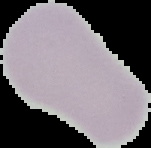

In [36]:
#just wanted to open the images
from PIL import Image
Image.open(uninfected[1])

In [37]:
#resizing images to standardize the data because it leads to more consistentcy from the model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#defines transformer and resizes images 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(), 
])
#loads dataset
dataset = datasets.ImageFolder(root='archive/cell_images', transform=transform)

#split the data into training, validating, and test. validating is used so we can see how the model looks while its training on it itself
#test is used so we can just test the model without seeing whats going on 
train_size = int(0.8 * len(dataset)) #training data is 80% of the dataset
val_size = len(dataset) - train_size #validating data is 20% of the dataset

#randomly splits the data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [38]:
import torch
import numpy as np

class Cutout:
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
# Train on clean images (no blur, no cutout)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validate on blurred/corrupted images
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    #transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

CUSTOM NEURAL NETWORK

In [63]:
import torch.nn as nn
import torch.nn.functional as func

# class NeuralNet(nn.Module):
#     def __init__ (self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 12, 5) #12 5x5 kernels that produce 12 feature maps
#         self.pool = nn.MaxPool2d(2, 2) #reduces each feature map by taking max in each 2x2 grid
#         self.conv2 = nn.Conv2d(12, 24, 5) #takes the 12 feature maps from conv1 and makes 24 5x5 kernels
#         self.fc1 = nn.Linear(24 * 29 * 29, 128) #takes the flattened 24 feature maps and outputs 128 features
#         self.fc2 = nn.Linear(128, 2) #maps 128 features to 2 classes (malaria or not)

#     def forward(self, x):
#         x = self.pool(func.relu(self.conv1(x)))
#         x = self.pool(func.relu(self.conv2(x)))
#         x = torch.flatten(x,1)
#         x = func.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class NeuralNet(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #32 3x3 kernels that produce 32 feature maps
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) #takes the 32 feature maps from conv1 and makes 64 3x3 kernels
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2) #reduces each feature map by taking max in each 2x2 grid
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 4 * 4, 512) #takes the flattened 128 feature maps and outputs 256 features
        self.fc2 = nn.Linear(512, 2) #maps 512 features to 2 classes (malaria or not)

    def forward(self, x):
        x = self.pool(func.relu(self.bn1(self.conv1(x))))
        x = self.pool(func.relu(self.bn2(self.conv2(x))))
        x = self.pool(func.relu(self.bn3(self.conv3(x))))

        x = self.adaptive_pool(x)#consistent size regardless of input
        x = torch.flatten(x,1)
        x = self.dropout(func.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [64]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

TRAINING AND TESTING BEFORE ADDING AUGMENTATIONS TO THE VALIDATION SET

In [65]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ----------------------
    # Validation evaluation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    # Cleaner log output
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step()


Epoch [1/5] - Train Loss: 0.3271, Train Acc: 86.52%, Val Loss: 0.2408, Val Acc: 92.27%
Epoch [2/5] - Train Loss: 0.1956, Train Acc: 93.35%, Val Loss: 0.1673, Val Acc: 94.19%
Epoch [3/5] - Train Loss: 0.1608, Train Acc: 94.91%, Val Loss: 0.1577, Val Acc: 94.72%
Epoch [4/5] - Train Loss: 0.1547, Train Acc: 95.14%, Val Loss: 0.1326, Val Acc: 95.75%
Epoch [5/5] - Train Loss: 0.1379, Train Acc: 95.58%, Val Loss: 0.1319, Val Acc: 95.50%


MODEL EVALUATION BEFORE THE AUGMENTATION (96%)

In [66]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    
print(f"Test Accuracy: {100* test_correct / test_total:.2f}%")

Test Accuracy: 95.50%


ADDING AUGMENTATIONS

In [67]:
from torchvision import transforms

AUGMENTATIONS = {
    "brightness": transforms.ColorJitter(brightness=(0.5, 1.5)),
    "gaussian_blur": transforms.GaussianBlur(kernel_size=5),
    "rotation": transforms.RandomRotation(degrees=15),
    "affine_shift": transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    "perspective": transforms.RandomPerspective(distortion_scale=0.3),
    "combo": transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.GaussianBlur(kernel_size=3),
    ])
}

EVALUATING THE MODEL ON EACH AUGMENTATION

In [68]:
from torch.utils.data import DataLoader
from copy import deepcopy
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
import torch

def evaluate_model_with_transform(model, test_dataset, transform, name=""):
    # clone and apply transform
    dataset_aug = deepcopy(test_dataset)
    dataset_aug.dataset.transform = Compose([Resize((128,128)), transform, ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    loader = DataLoader(dataset_aug, batch_size=32)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Test Accuracy ({name}): {acc:.2f}%")
    
    return acc


MODEL EVALUATON ON EACH AUGMENTATION ON THE VALIDATON SET

In [69]:
for name, aug in AUGMENTATIONS.items():
    evaluate_model_with_transform(model, val_dataset, aug, name)


Test Accuracy (brightness): 93.45%
Test Accuracy (gaussian_blur): 95.46%
Test Accuracy (rotation): 95.59%
Test Accuracy (affine_shift): 94.92%
Test Accuracy (perspective): 95.36%
Test Accuracy (combo): 93.81%


MODEL EVALUATION AFTER APPLYING THE "CUTOUT

In [70]:
import random

# Make sure model is in eval mode
model.eval()
test_correct = 0
test_total = 0

# Instantiate your Cutout class
cutout = Cutout(n_holes=1, length=32)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Apply Cutout to each image in the batch
        images = torch.stack([
            cutout(img.clone()) for img in images
        ])

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Cutout): {100 * test_correct / test_total:.2f}%")


Test Accuracy (Cutout): 94.05%


In [73]:
import torch.nn.functional as F

def reduce_resolution(img_tensor, low_res_size=32, orig_size=128):
    img_tensor = img_tensor.unsqueeze(0)  
    low_res = F.interpolate(img_tensor, size=(low_res_size, low_res_size), mode='bicubic', align_corners=False)
    upscaled = F.interpolate(low_res, size=(orig_size, orig_size), mode='bicubic', align_corners=False)
    return upscaled.squeeze(0)  

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([
            reduce_resolution(img.clone(), low_res_size=32, orig_size=128) for img in images
        ])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Low Resolution): {100 * test_correct / test_total:.2f}%")

Test Accuracy (Low Resolution): 94.27%


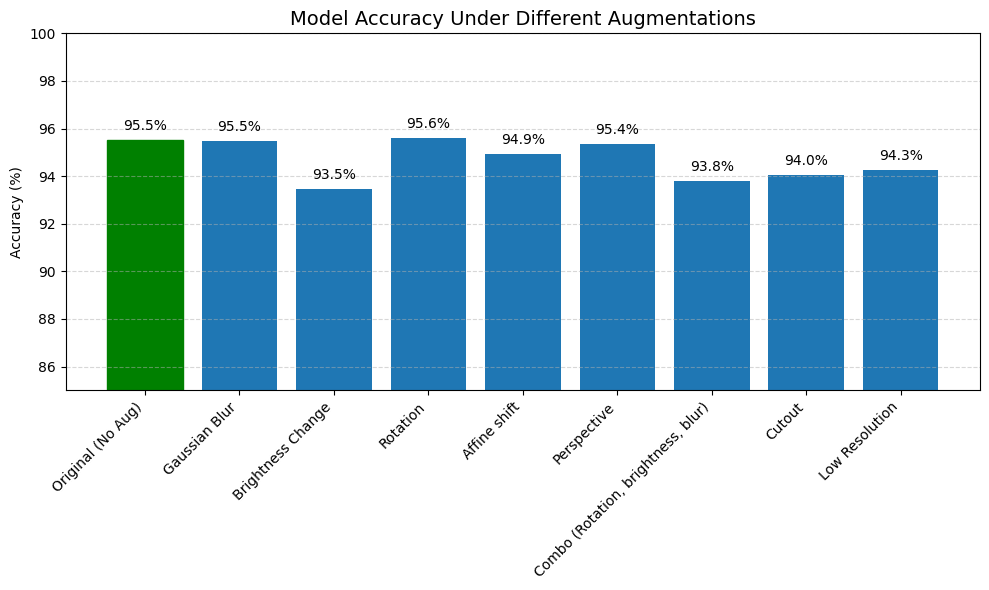

In [72]:
results = {
    "Original (No Aug)": 95.5,
    "Gaussian Blur": 95.46,
    "Brightness Change": 93.45,
    "Rotation": 95.59,
    "Affine shift": 94.92,
    "Perspective": 95.36,
    "Combo (Rotation, brightness, blur)": 93.81,
    "Cutout": 94.05,
    "Low Resolution" : 94.27

}

import matplotlib.pyplot as plt

# Labels and values
labels = list(results.keys())
accuracies = list(results.values())

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies)

# Highlight original in a different color
bars[0].set_color('green')  # Original (no aug)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.3,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Aesthetics
plt.title('Model Accuracy Under Different Augmentations', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(85, 100)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()
